In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

In [3]:
!pip install numpy_groupies -q

# Dask start

In [4]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46231")
client

<Client: 'tcp://127.0.0.1:46231' processes=4 threads=8, memory=29.40 GiB>

# Import

In [46]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import xrft_module
import pandas as pd
import xesmf as xe
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew
import pandas as pd

In [6]:
# import imp
# imp.reload(xrft_module)

# Load data

Load Pangeo catalog

In [7]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [8]:
# x_slice = slice(400,700)
# y_slice = slice(500,800)

x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,200),y=y_slice,x=x_slice)

coord_slice = dict(y=y_slice,x=x_slice)

In [9]:
dataSetsHR=[]

for region in ['1', '2', '3'] :
    for season in ['fma', 'aso'] :
        current_set = cat.eNATL60(region=region,datatype='surface_hourly', season=season).to_dask().\
        chunk({'time_counter' : 1, 'x' : -1, 'y' : -1})[data_slice].\
        drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
        current_set['tmask'] = current_set.tmask.astype(np.float32)
        current_set.load()
        current_set['x'] = np.arange(len(current_set['x']))
        current_set['y'] = np.arange(len(current_set['y']))
        dataSetsHR.append({'region': region, 'season' : season, 'data': current_set})

In [10]:
selected_data_set = dataSetsHR[0]['data']

In [11]:
selected_data_set

<xarray.Dataset>
Dimensions:        (time_counter: 11, x: 610, y: 762)
Coordinates: (12/17)
    depth          (y, x) float32 819.0 813.6 813.6 ... 2.413e+03 2.434e+03
    e1f            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e1t            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e1u            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e1v            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e2f            (y, x) float64 1.564e+03 1.564e+03 ... 1.332e+03 1.332e+03
    ...             ...
    nav_lat        (y, x) float32 30.0 30.0 30.0 30.0 ... 39.98 39.98 39.98
    nav_lon        (y, x) float32 -78.01 -77.99 -77.97 ... -68.05 -68.04 -68.02
    time_centered  (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 602 603 604 605 606 607 608 609
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 754 755 756 757 758 759 760 761
Data variables:
    sosaline       (time_counter, y, x) float32 36.53 36.53 36.51 ... 36.29 36.3
    sosstsst       (time_counter, y, x) float32 22.26 22.29 22.3 ... 19.38 19.41
    tmask          (y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0

In [12]:
#selected_data_set.to_netcdf("Data/region"+dataSetsHR[i]['region']+"_"+dataSetsHR[i]['season']+".nc")

CPU times: user 1.26 s, sys: 46.1 ms, total: 1.3 s
Wall time: 1.3 s


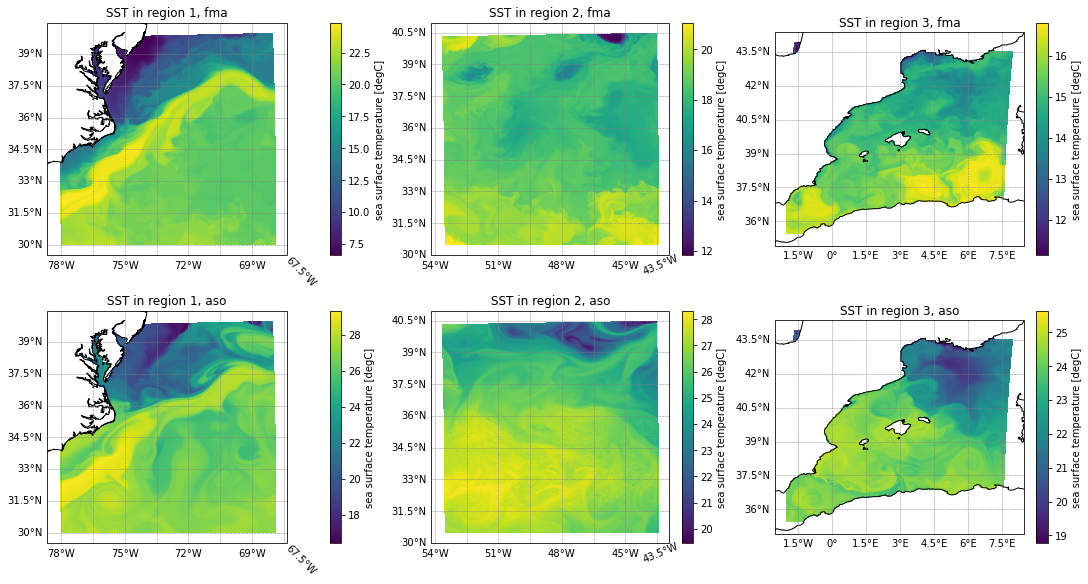

In [13]:
%%time
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsHR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosstsst[coord_slice].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].coastlines()
    gl = ax[row,col].gridlines(draw_labels=True, x_inline=False, y_inline=False, 
              color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False
#plt.savefig('Images/SST_vs_region_season.png')

CPU times: user 1.24 s, sys: 49.4 ms, total: 1.29 s
Wall time: 1.28 s


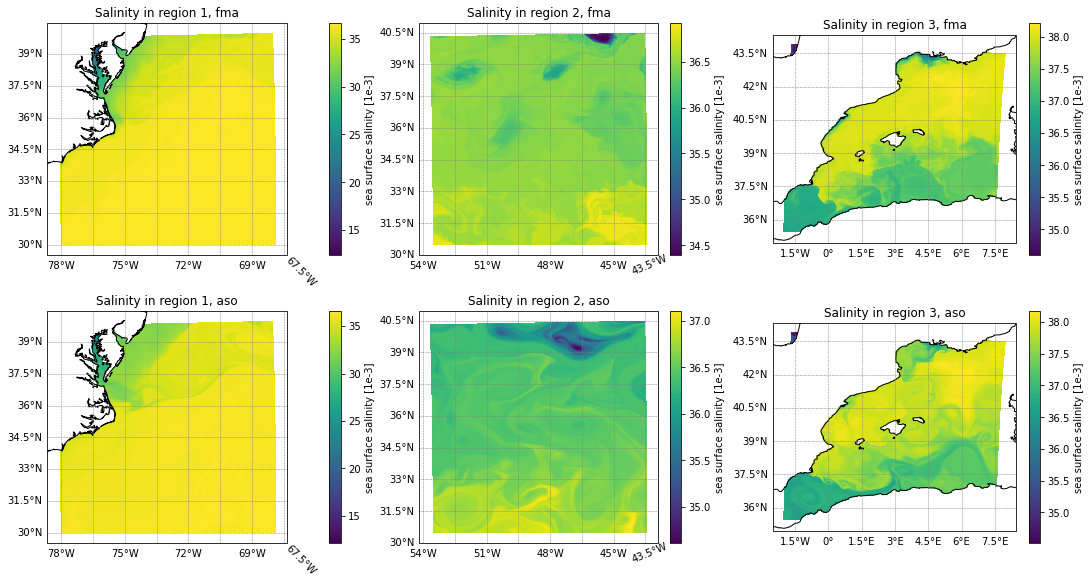

In [14]:
%%time
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsHR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosaline[coord_slice].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='Salinity in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].coastlines()
    gl = ax[row,col].gridlines(draw_labels=True, x_inline=False, y_inline=False, 
              color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False
#plt.savefig('Images/Salinity_vs_region_season.png')

# Filter

Parameters (to determine) :

In [15]:
filter_scale = 30000
coarsening_window_size=12

In [16]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=False).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    new_e2t = data['e2t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=False).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    return result

In [17]:
def apply_filter_downsample(dataHR) :
    area = xr.DataArray((dataHR.e1t * dataHR.e2t), dims=['y','x'])
    dxw = xr.DataArray(dataHR.e1u, dims=['y','x']) # x-spacing centered at western cell edge
    dyw = xr.DataArray(dataHR.e2u, dims=['y','x']) # y-spacing centered at western cell edge
    dxs = xr.DataArray(dataHR.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
    dys = xr.DataArray(dataHR.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
    dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
    wet_mask = xr.DataArray(dataHR.tmask, dims=['y','x'])
    kappa_w = xr.ones_like(dxw)
    kappa_s = xr.ones_like(dxw)
    # define the filter
    gaussian_filter = gcm_filters.Filter(
        filter_scale=filter_scale,    
        dx_min=dx_min,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
            'kappa_w': kappa_w, 'kappa_s': kappa_s} )
    # apply filter to HR data
    data_filtered = xr.Dataset({}, coords=dataHR.coords)
    data_filtered = gaussian_filter.apply(dataHR, dims=['y', 'x'])
    # spatial coarsening
    dataLR = downsample(data_filtered, coarsening_window_size, area, wet_mask)
    return dataLR

# Downgraded data

In [18]:
dataSetsLR = []

In [19]:
for dataHR in dataSetsHR :
    %time dataLR = apply_filter_downsample(dataHR['data']).compute()
    dataSetsLR.append({'region': dataHR['region'], 'season' : dataHR['season'], 'data': dataLR})

CPU times: user 13.4 s, sys: 6.38 s, total: 19.8 s
Wall time: 19 s
CPU times: user 14.4 s, sys: 6.76 s, total: 21.1 s
Wall time: 20.3 s
CPU times: user 11.9 s, sys: 4.21 s, total: 16.1 s
Wall time: 15.3 s
CPU times: user 12.9 s, sys: 4.63 s, total: 17.6 s
Wall time: 16.8 s
CPU times: user 11.9 s, sys: 4.23 s, total: 16.1 s
Wall time: 15.3 s
CPU times: user 12.4 s, sys: 4.39 s, total: 16.8 s
Wall time: 16 s


In [20]:
x_slice = slice(0,-1)
y_slice = slice(2,-1)

bord_cut = dict(y=y_slice,x=x_slice)

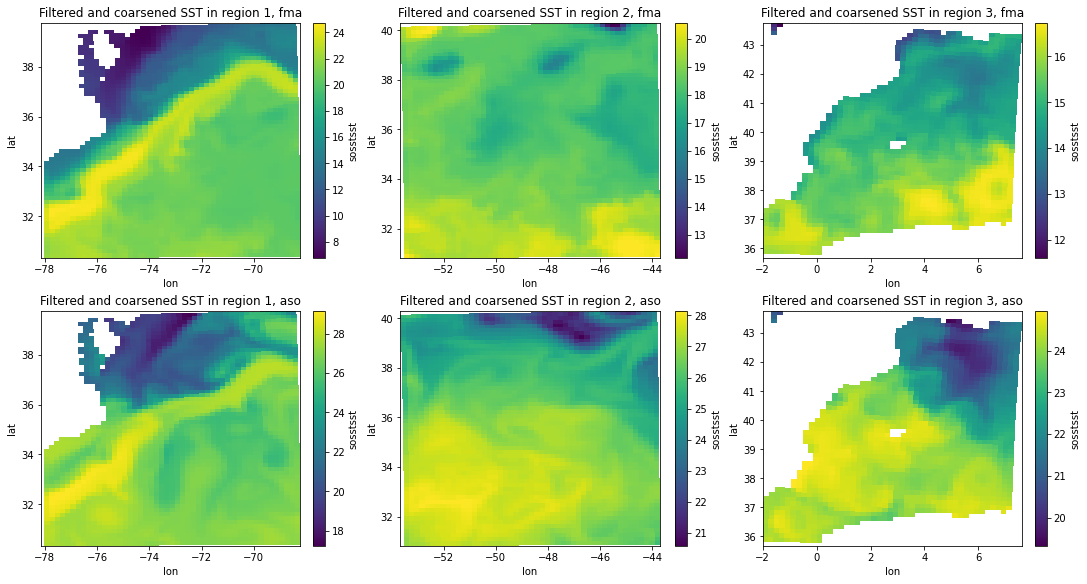

In [21]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsLR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosstsst[bord_cut].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='Filtered and coarsened SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
#plt.savefig('Images/SST_filtered_downsampled_vs_region_season.png')

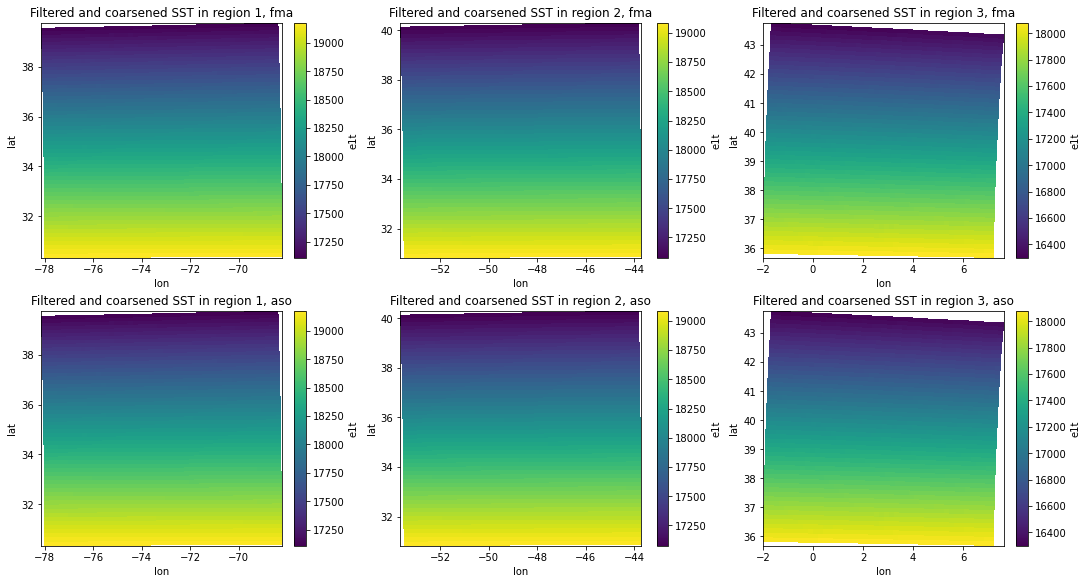

In [22]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsLR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].e1t[bord_cut].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='Filtered and coarsened SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
#plt.savefig('Images/SST_filtered_downsampled_vs_region_season.png')

# Spectra

In [23]:
def uniform_grid_interpolation(data) :
    # first fill in nans
    if (np.isnan(data).any()) : 
        data_filled_nans = data.interpolate_na(dim="x", method="linear")
        data_filled_nans = data_filled_nans.interpolate_na(dim="y", method="linear")
        data_filled_nans = data_filled_nans.interpolate_na(dim="x", method="nearest", fill_value="extrapolate")
    else :
        data_filled_nans = data
    # transform coordinates to uniform spacings
    delta_x_min_m = data['e1t'].min().values
    delta_y_min_m = data['e2t'].min().values
    delta_min = np.min([delta_x_min_m, delta_y_min_m])
    new_x = np.cumsum(delta_min/data['e1t'], axis=1)
    new_y = np.cumsum(delta_min/data['e2t'], axis=0)
    interpolated_field = data_filled_nans.interp(x=new_x, y=new_y).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    interpolated_field.attrs['delta_min'] = delta_min
    return interpolated_field

In [24]:
def wrapper_xrtf_isotropic_PS(data, variable, binning_factor=4) :
    interpolated_data = uniform_grid_interpolation(data[variable])
    isotropic_power_spec = xrft_module.isotropic_power_spectrum(interpolated_data, dim=['x','y'], detrend='linear',scaling="spectrum", nfactor=binning_factor, truncate=True)
    Nmin = min([len(data['x']), len(data['y'])])
    isotropic_power_spec.coords['wavenumber'] = ('freq_r', isotropic_power_spec['freq_r']/(Nmin*interpolated_data.attrs['delta_min']*0.001))
    return isotropic_power_spec.rename('Spatial spectrum')

In [25]:
# for currentDataSet in dataSetsLR :
#     spec_temp_variance = wrapper_xrtf_isotropic_PS(currentDataSet['data'][bord_cut], 'sosstsst', binning_factor = 2)
#     %time currentDataSet['mean_spec_temp_variance'] = spec_temp_variance.mean(dim='time_counter').compute()
#     mean_spec_temp_variance.to_netcdf("Data/filter_30km_coarse_12_mean_spec_temp_variance_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")

In [26]:
# fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(5,4))
# for currentDataSet in dataSetsLR :
#     currentDataSet['mean_spec_temp_variance'].plot(x='wavenumber',ax=ax, ls='-', marker='o',\
#                                                    label='Region '+currentDataSet['region']+', '+currentDataSet['season'])
# ax.set(xscale='log', yscale='log'); ax.grid(True)
# ax.legend()
# plt.show()

In [27]:
# for currentDataSet in dataSetsHR :
#     spec_temp_variance = wrapper_xrtf_isotropic_PS(currentDataSet['data'], 'sosstsst', binning_factor = 2)
#     %time mean_spec_temp_variance = spec_temp_variance.mean(dim='time_counter').compute()
#     mean_spec_temp_variance.to_netcdf("Data/mean_spec_temp_variance_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")

# Histograms

## Salinity and SST

In [28]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t).where(dataSet.tmask >0), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum()).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = hist/hist.sum()
    return norm_hist

In [29]:
nb_of_bins = 150

In [30]:
for currentDataSet in dataSetsLR :
    %time currentDataSet['histogram_temp_sal'] = compute_2D_histogram(currentDataSet['data'][bord_cut], 'sosaline', 'sosstsst', nb_of_bins).compute()
    currentDataSet['histogram_temp_sal'].to_netcdf("Data/Compare_histograms/filter_30km_coarse_12_hist_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")

CPU times: user 17.8 ms, sys: 1.93 ms, total: 19.8 ms
Wall time: 18.1 ms
CPU times: user 16.3 ms, sys: 106 µs, total: 16.4 ms
Wall time: 16.4 ms
CPU times: user 16.3 ms, sys: 0 ns, total: 16.3 ms
Wall time: 16.3 ms
CPU times: user 16.8 ms, sys: 0 ns, total: 16.8 ms
Wall time: 16.8 ms
CPU times: user 15.5 ms, sys: 187 µs, total: 15.7 ms
Wall time: 15.7 ms
CPU times: user 16.2 ms, sys: 66 µs, total: 16.3 ms
Wall time: 16.3 ms


In [31]:
for currentDataSet in dataSetsHR :
    %time currentDataSet['histogram_temp_sal'] = compute_2D_histogram(currentDataSet['data'], 'sosaline', 'sosstsst', nb_of_bins).compute()
    currentDataSet['histogram_temp_sal'].to_netcdf("Data/Compare_histograms/hist_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")

CPU times: user 296 ms, sys: 94.6 ms, total: 390 ms
Wall time: 387 ms
CPU times: user 323 ms, sys: 83.8 ms, total: 406 ms
Wall time: 405 ms
CPU times: user 321 ms, sys: 84.7 ms, total: 406 ms
Wall time: 405 ms
CPU times: user 327 ms, sys: 82.1 ms, total: 410 ms
Wall time: 409 ms
CPU times: user 237 ms, sys: 70 ms, total: 307 ms
Wall time: 306 ms
CPU times: user 267 ms, sys: 69.9 ms, total: 337 ms
Wall time: 336 ms


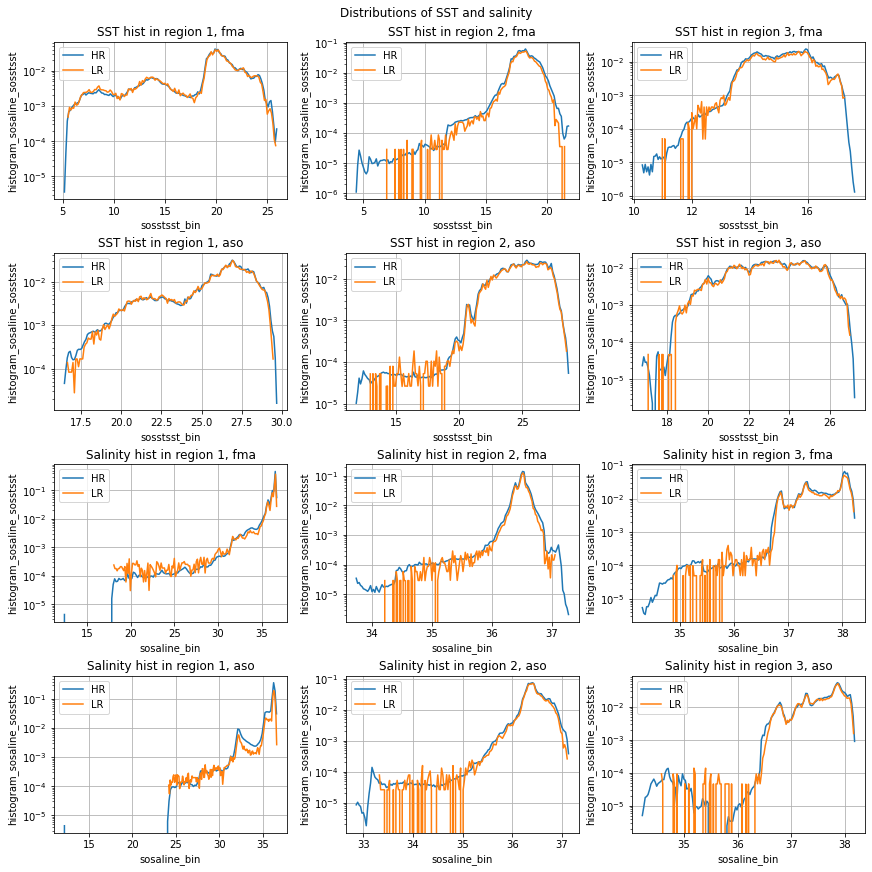

In [32]:
fig, ax = plt.subplots(ncols=3, nrows=4, constrained_layout=True, figsize=(12,12))
fig.suptitle('Distributions of SST and salinity')
for i in range(len(dataSetsLR)) :
    #histogramsLR = xr.open_dataset("Data/Compare_histograms/filter_30km_coarse_12_hist_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    #histogramsHR = xr.open_dataset("Data/Compare_histograms/hist_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    # temperature PDFs
    hist_temp_LR = dataSetsLR[i]['histogram_temp_sal'].sum(dim='sosaline_bin')
    hist_temp_HR = dataSetsHR[i]['histogram_temp_sal'].sum(dim='sosaline_bin')
    col = int(dataSetsLR[i]['region'])-1
    if (dataSetsLR[i]['season'] == 'aso') : row=1
    if (dataSetsLR[i]['season'] == 'fma') : row=0
    hist_temp_HR.plot(ax=ax[row,col], label='HR')
    hist_temp_LR.plot(ax=ax[row,col], label='LR')
    ax[row,col].set(yscale='log',title='SST hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)
    # salinity PDFs
    hist_sal_LR = dataSetsLR[i]['histogram_temp_sal'].sum(dim='sosstsst_bin')
    hist_sal_HR = dataSetsHR[i]['histogram_temp_sal'].sum(dim='sosstsst_bin')
    if (dataSetsLR[i]['season'] == 'aso') : row=3
    if (dataSetsLR[i]['season'] == 'fma') : row=2
    hist_sal_HR.plot(ax=ax[row,col], label='HR')
    hist_sal_LR.plot(ax=ax[row,col], label='LR')
    ax[row,col].set(yscale='log',title='Salinity hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)

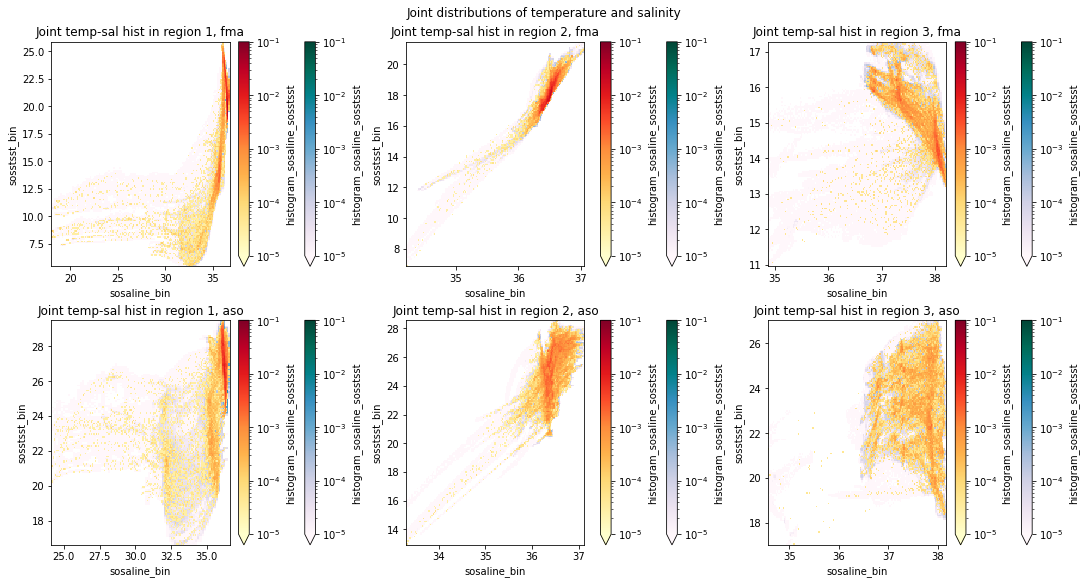

In [33]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
fig.suptitle('Joint distributions of temperature and salinity')
for i,currentDataSet in enumerate(dataSetsLR) :
    #histogram_LR = xr.open_dataset("Data/Compare_histograms/filter_30km_coarse_12_hist_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    #histogram_HR = xr.open_dataset("Data/Compare_histograms/hist_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    dataSetsHR[i]['histogram_temp_sal'].plot(x='sosaline_bin', y='sosstsst_bin', ax=ax[row,col], label='HR',norm=colors.LogNorm(vmin=1e-5, vmax=0.1), cmap='PuBuGn')
    currentDataSet['histogram_temp_sal'].plot(x='sosaline_bin', y='sosstsst_bin', ax=ax[row,col], label='LR',norm=colors.LogNorm(vmin=1e-5, vmax=0.1), cmap='YlOrRd')
    ax[row,col].set(title='Joint temp-sal hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    #ax[row,col].legend()

## Gradients

In [34]:
def gradx(dataArray, delta_x) :
    return (dataArray.shift(x=-1) - dataArray)/delta_x
def grady(dataArray, delta_y) :
    return (dataArray.shift(y=-1) - dataArray)/delta_y

In [35]:
def diffx(dataArray) :
    return (dataArray.shift(x=-1) - dataArray)
def diffy(dataArray) :
    return (dataArray.shift(y=-1) - dataArray)

In [36]:
def add_spatial_grad_to_dataset(input_dataset) :
    return xr.merge([input_dataset,
                      xr.DataArray(np.sqrt(gradx(input_dataset.sosstsst, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosstsst, input_dataset.e2t)**2),\
                                   name='grad_temp'),
                      xr.DataArray(np.sqrt(gradx(input_dataset.sosaline, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosaline, input_dataset.e2t)**2),\
                                   name='grad_sal')]).chunk({'time_counter' : 1, 'x' : -1, 'y' : -1})

In [37]:
%%timeit
for i in range(len(dataSetsLR)) :
    currentDataSet = dataSetsLR[i]
    currentDataSet['data'] = add_spatial_grad_to_dataset(currentDataSet['data'])
    currentDataSet['hist_grads'] = compute_2D_histogram(currentDataSet['data'], 'grad_sal', 'grad_temp', nb_of_bins).compute()
    currentDataSet['hist_grads'].to_netcdf("Data/Compare_histograms/filter_30km_coarse_12_hist_grad_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")
    
    currentDataSet = dataSetsHR[i]
    currentDataSet['data'] = add_spatial_grad_to_dataset(currentDataSet['data'])
    currentDataSet['hist_grads'] = compute_2D_histogram(currentDataSet['data'], 'grad_sal', 'grad_temp', nb_of_bins, \
                                      bins=[dataSetsLR[i]['hist_grads'].grad_sal_bin.values, dataSetsLR[i]['hist_grads'].grad_temp_bin.values]).compute()
    currentDataSet['hist_grads'].to_netcdf("Data/Compare_histograms/hist_grad_sal_temp_HR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")

14.8 s ± 747 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


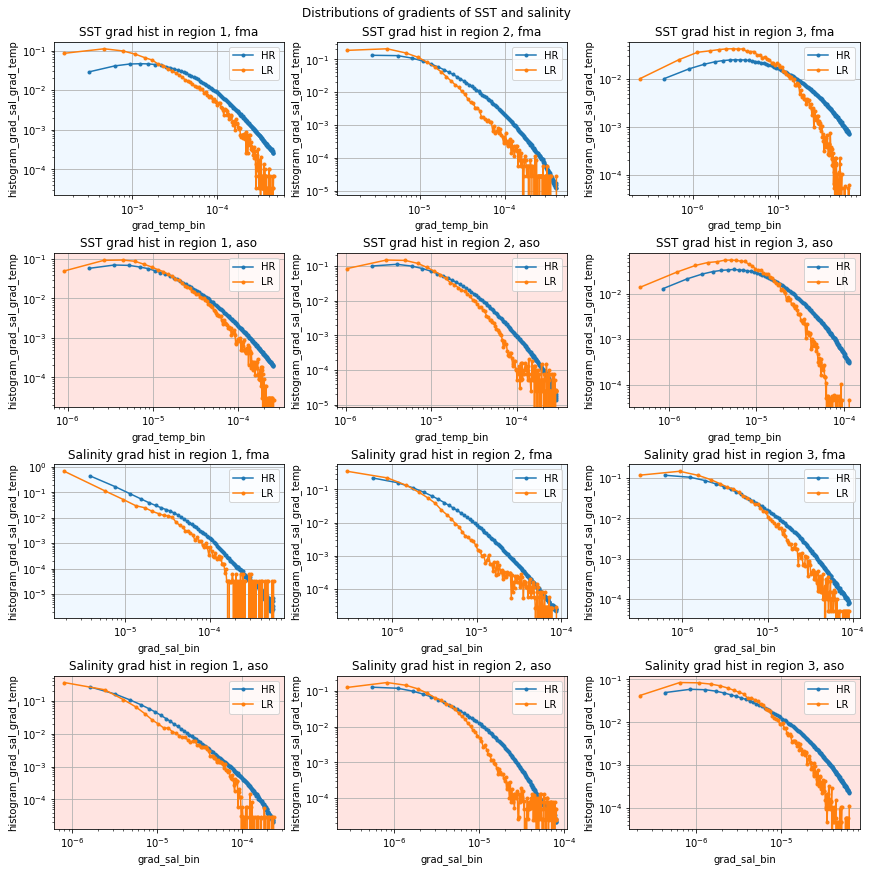

In [38]:
fig, ax = plt.subplots(ncols=3, nrows=4, constrained_layout=True, figsize=(12,12))
fig.suptitle('Distributions of gradients of SST and salinity')
for i in range(len(dataSetsLR)) :
    #histogramsLR = xr.open_dataset("Data/Compare_histograms/filter_30km_coarse_12_hist_grad_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    #histogramsHR = xr.open_dataset("Data/Compare_histograms/hist_grad_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    # temperature PDFs
    hist_temp_LR = dataSetsLR[i]['hist_grads'].sum(dim='grad_sal_bin')
    hist_temp_HR = dataSetsHR[i]['hist_grads'].sum(dim='grad_sal_bin')
    col = int(dataSetsLR[i]['region'])-1
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=1; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=0; ax[row,col].set_facecolor('aliceblue')
    hist_temp_HR.plot(ax=ax[row,col], label='HR', ls='-', marker='.')
    hist_temp_LR.plot(ax=ax[row,col], label='LR', ls='-', marker='.')
    ax[row,col].set(yscale='log', xscale='log', title='SST grad hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)
    # salinity PDFs
    hist_sal_LR = dataSetsLR[i]['hist_grads'].sum(dim='grad_temp_bin')
    hist_sal_HR = dataSetsHR[i]['hist_grads'].sum(dim='grad_temp_bin')
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=3; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=2; ax[row,col].set_facecolor('aliceblue')
    hist_sal_HR.plot(ax=ax[row,col], label='HR', ls='-', marker='.')
    hist_sal_LR.plot(ax=ax[row,col], label='LR', ls='-', marker='.')
    ax[row,col].set(yscale='log', xscale='log', title='Salinity grad hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)

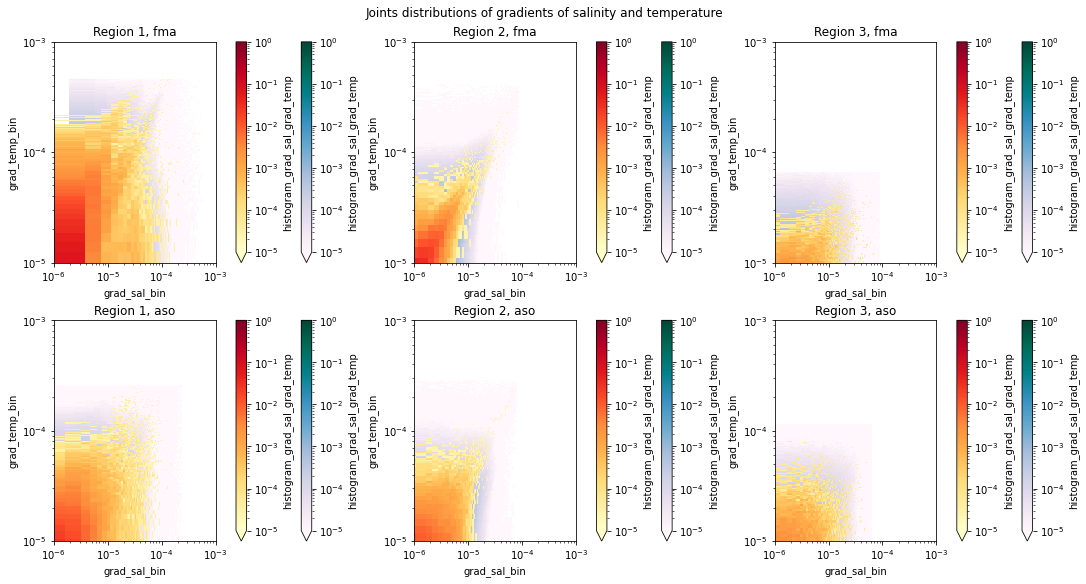

In [39]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
fig.suptitle('Joints distributions of gradients of salinity and temperature')
for i in range(len(dataSetsLR)) :
    #histogram_tempLR = xr.open_dataset("Data/Compare_histograms/filter_30km_coarse_12_hist_grad_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    #histogram_tempHR = xr.open_dataset("Data/Compare_histograms/hist_grad_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    col = int(dataSetsHR[i]['region'])-1
    if (dataSetsHR[i]['season'] == 'aso') : row=1
    if (dataSetsHR[i]['season'] == 'fma') : row=0
    dataSetsHR[i]['hist_grads'].plot(x='grad_sal_bin', y='grad_temp_bin', ax=ax[row,col], label='HR',norm=colors.LogNorm(vmin=1e-5, vmax=1), cmap='PuBuGn')
    dataSetsLR[i]['hist_grads'].plot(x='grad_sal_bin', y='grad_temp_bin', ax=ax[row,col], label='LR',norm=colors.LogNorm(vmin=1e-5, vmax=1), cmap='YlOrRd')
    ax[row,col].set(yscale='log', xscale='log', title='Region ' + dataSetsHR[i]['region'] + ', '+dataSetsHR[i]['season'])
    ax[row,col].set(xlim=[1e-6, 1e-3], ylim=[1e-5, 1e-3])
    #ax[row,col].legend()

## Second derivatives of density 

In [50]:
def add_density_derivatives(input_dataset) :
    # conservatice temperature
    CT = xr.apply_ufunc(gsw.conversions.CT_from_pt, input_dataset.sosaline, input_dataset.sosstsst, dask='parallelized')
    alpha, beta = eos_module.alpha_beta(input_dataset.sosaline, CT)
    rho_sa_sa, rho_sa_ct, rho_ct_ct = eos_module.rho_second_derivatives(input_dataset.sosaline, CT)
    return xr.merge([input_dataset,
                      xr.DataArray(alpha, name='alpha'),
                      xr.DataArray(beta, name='beta'),
                      xr.DataArray(rho_sa_sa, name='rho_sa_sa'),
                      xr.DataArray(rho_sa_ct, name='rho_sa_ct'),
                      xr.DataArray(rho_ct_ct, name='rho_ct_ct')]).chunk({'time_counter' : 1, 'x' : -1, 'y' : -1})

In [51]:
rho0 = 0.1 # for non-dimesionalization

In [62]:
%%timeit
for currentDataSet in (dataSetsLR+dataSetsHR) :
    currentDataSet['data'] = add_density_derivatives(currentDataSet['data'])
    currentDataSet['data']['non_dim_diff_T_sqr'] = xr.DataArray(1./rho0*np.abs(currentDataSet['data'].rho_ct_ct)*(diffx(currentDataSet['data'].sosstsst)**2+diffy(currentDataSet['data'].sosstsst)**2),\
                                      name='non_dim_grad_T_sqr').chunk({'time_counter' : 1, 'x' : -1, 'y' : -1})
    currentDataSet['data']['non_dim_diff_S_sqr'] = xr.DataArray(1./rho0*np.abs(currentDataSet['data'].rho_sa_sa)*(diffx(currentDataSet['data'].sosaline)**2+diffy(currentDataSet['data'].sosaline)**2), \
                                      name='non_dim_grad_S_sqr').chunk({'time_counter' : 1, 'x' : -1, 'y' : -1})
    currentDataSet['nondim_hist_diff_temp_sal'] = compute_2D_histogram(currentDataSet['data'], \
                                                                       'non_dim_diff_T_sqr', 'non_dim_diff_S_sqr', nb_of_bins).compute()
    #currentDataSet['nondim_hist_diff_temp_sal'].to_netcdf("Data/Compare_histograms/filter_30km_coarse_12_hist_nondim_diff_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")
    #currentDataSet['nondim_hist_diff_temp_sal'].to_netcdf("Data/Compare_histograms/hist_diff_sal_temp_HR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")

53.8 s ± 687 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


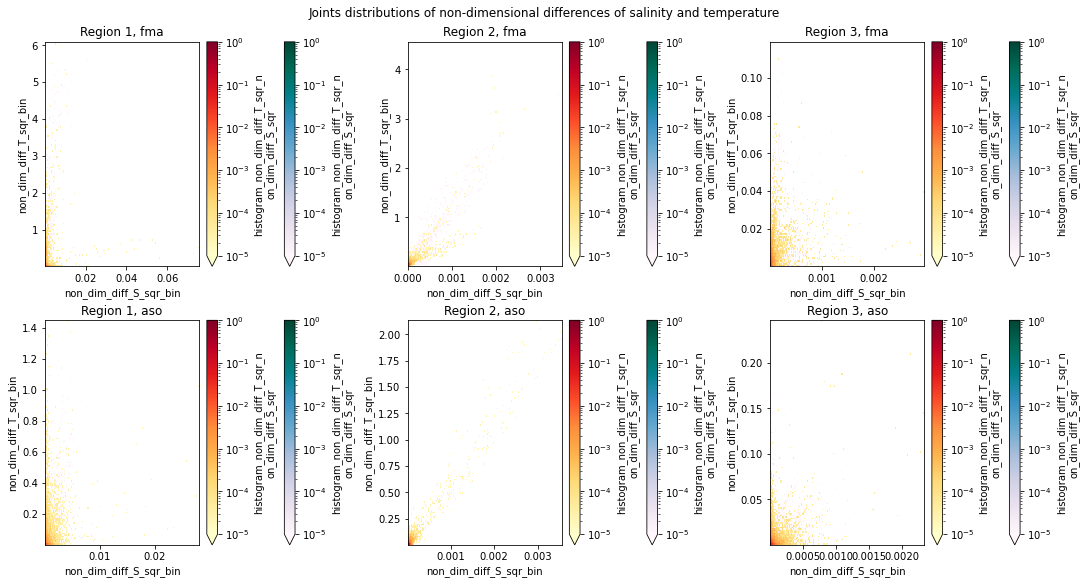

In [68]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
fig.suptitle('Joints distributions of non-dimensional differences of salinity and temperature')
for i in range(len(dataSetsLR)) :
    #histogram_tempLR = xr.open_dataset("Data/Compare_histograms/filter_30km_coarse_12_hist_nondim_grad_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    #histogram_tempHR = xr.open_dataset("Data/Compare_histograms/hist_nondim_grad_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
    col = int(dataSetsHR[i]['region'])-1
    if (dataSetsHR[i]['season'] == 'aso') : row=1
    if (dataSetsHR[i]['season'] == 'fma') : row=0
    dataSetsHR[i]['nondim_hist_diff_temp_sal'].plot(x='non_dim_diff_S_sqr_bin', y='non_dim_diff_T_sqr_bin', ax=ax[row,col], label='HR',norm=colors.LogNorm(vmin=1e-5, vmax=1), cmap='PuBuGn')
    dataSetsLR[i]['nondim_hist_diff_temp_sal'].plot(x='non_dim_diff_S_sqr_bin', y='non_dim_diff_T_sqr_bin', ax=ax[row,col], label='LR',norm=colors.LogNorm(vmin=1e-5, vmax=1), cmap='YlOrRd')
    ax[row,col].set(title='Region ' + dataSetsHR[i]['region'] + ', '+dataSetsHR[i]['season'])
    #ax[row,col].legend()

# Statistical moments of gradients distribution

In [86]:
%%timeit
for currentDataSet in (dataSetsLR+dataSetsHR) :
    currentDataSet['mean_temp'] = np.mean(currentDataSet['data'].sosstsst,axis=None)
    currentDataSet['var_temp'] = np.var(currentDataSet['data'].sosstsst,axis=None)
    currentDataSet['skew_temp'] = skew(currentDataSet['data'].sosstsst,axis=None, bias=False, nan_policy='omit')
    currentDataSet['kurt_temp'] = kurtosis(currentDataSet['data'].sosstsst,axis=None,fisher=False, bias=False, nan_policy='omit')

In [87]:
for currentDataSet in (dataSetsLR) :
    print('Skewness of region '+currentDataSet['region']+', '+currentDataSet['season']+': ', currentDataSet['skew_temp'])

Skewness of region 1, fma:  -1.0917324114128453
Skewness of region 1, aso:  -1.0703035804544099
Skewness of region 2, fma:  -1.3299691469628085
Skewness of region 2, aso:  -0.7312290220459641
Skewness of region 3, fma:  -0.12605478536411463
Skewness of region 3, aso:  -0.24355532667819205


In [88]:
for currentDataSet in (dataSetsLR) :
    print('Kurtosis of region '+currentDataSet['region']+', '+currentDataSet['season']+': ', currentDataSet['kurt_temp'])

Kurtosis of region 1, fma:  3.272943692164057
Kurtosis of region 1, aso:  3.365142517647676
Kurtosis of region 2, fma:  11.447633008419965
Kurtosis of region 2, aso:  4.464147245887835
Kurtosis of region 3, fma:  2.570974615457718
Kurtosis of region 3, aso:  2.32994635348728
